In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [3]:
file_path = './vehicles/vehicles.csv'
df = pd.read_csv(file_path)

The attributes that we are working with:

In [4]:
print(df.head())

   cena       marka    model  godina proizvodnje  kilometraža karoserija  \
0  8650       Škoda  Octavia                2016       196000    Karavan   
1  3500     Peugeot      207                2009       243892     Hečbek   
2  7000        Audi       A4                2008       211429   Limuzina   
3  1450  Alfa Romeo      147                2008       315000     Hečbek   
4  2899     Peugeot      307                2008       190000    Karavan   

   gorivo  kubikaža  snaga motora                       menjač broj vrata  \
0   Dizel      1968           150            Manuelni 6 brzina  4/5 vrata   
1   Dizel      1560            90            Manuelni 5 brzina  4/5 vrata   
2  Benzin      1798           160            Manuelni 6 brzina  4/5 vrata   
3   Dizel      1910           120            Manuelni 6 brzina  4/5 vrata   
4   Dizel      1997           136  Automatski / poluautomatski  4/5 vrata   

              klima  
0  Automatska klima  
1    Manuelna klima  
2    Manuelna 

Basic statistics about the dataset:

In [5]:
print(df.describe())

                cena  godina proizvodnje   kilometraža      kubikaža  \
count   58622.000000        58622.000000  5.862200e+04  5.862200e+04   
mean     9700.740643         2009.516905  2.086623e+05  3.136385e+03   
std     12993.540219            6.593926  1.338493e+05  1.552663e+05   
min         0.000000         1927.000000  0.000000e+00  0.000000e+00   
25%      3200.000000         2006.000000  1.654000e+05  1.496000e+03   
50%      5800.000000         2009.000000  2.040000e+05  1.895000e+03   
75%     11500.000000         2014.000000  2.490000e+05  1.995000e+03   
max    360000.000000         2024.000000  3.960000e+06  2.148215e+07   

       snaga motora  
count  58622.000000  
mean     132.965849  
std       57.838515  
min       18.000000  
25%      101.000000  
50%      120.000000  
75%      150.000000  
max      935.000000  


Missing values in the dataset:

In [6]:
print(df.isnull().sum()) # Detect missing values
df = df.dropna() # Remove null values

cena                  0
marka                 0
model                 0
godina proizvodnje    0
kilometraža           0
karoserija            2
gorivo                0
kubikaža              0
snaga motora          0
menjač                0
broj vrata            1
klima                 1
dtype: int64


The following image is a basic distribution of numerical features which shows an obvious presence of pure single-factor outliers. By examining the data by hand, we determined that some of them were data-entry mistakes made by the website users, for example mistaking the unit for engine displacement or adding an accidental zero to the mileage, and other were real cases of rare values, such as vehicles with 800+ horepower, or 500_000+ kilometres.

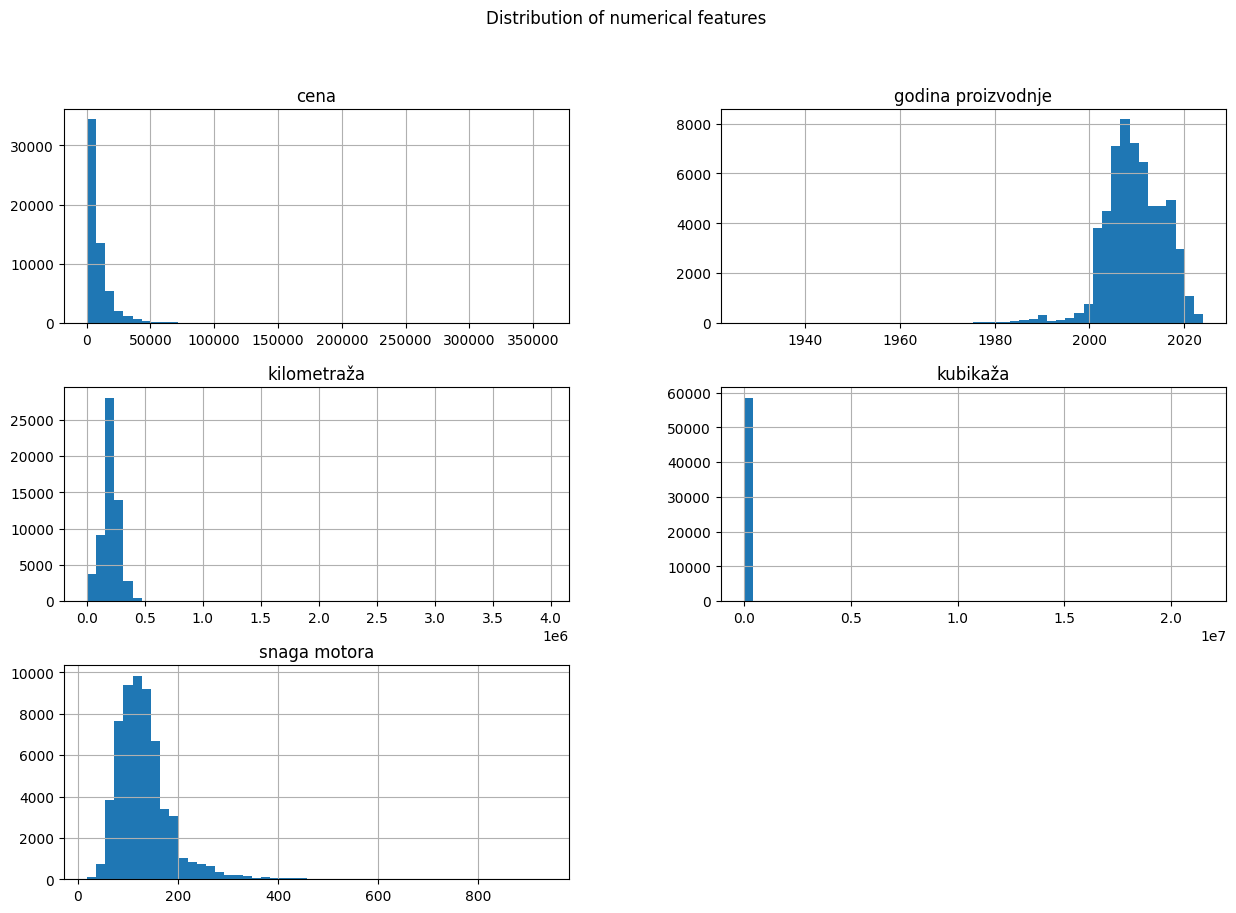

In [7]:
numerical_features = ['cena', 'godina proizvodnje', 'kilometraža', 'kubikaža', 'snaga motora']
df[numerical_features].hist(bins=50, figsize=(15, 10))
plt.suptitle('Distribution of numerical features')
plt.show()

The price graph has shown a very obvious right skewness which is normally dealt with using a log transformation. The following images show the result of that transformation.

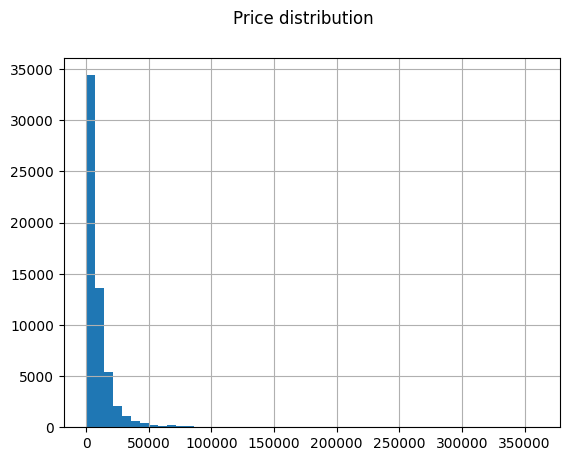

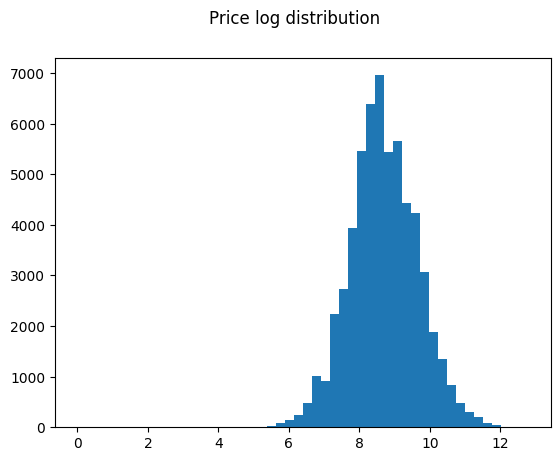

In [8]:
df['cena'].hist(bins=50)
plt.suptitle('Price distribution')
plt.show()

df = df[df['cena'] > 0]
plt.hist(np.log(df['cena']), bins=50)
plt.suptitle('Price log distribution')
plt.show()

# df['cena'] = np.log(df['cena'])

Here, we sought to see how finding and removing outliers with a statistical (zscore) approach would work.

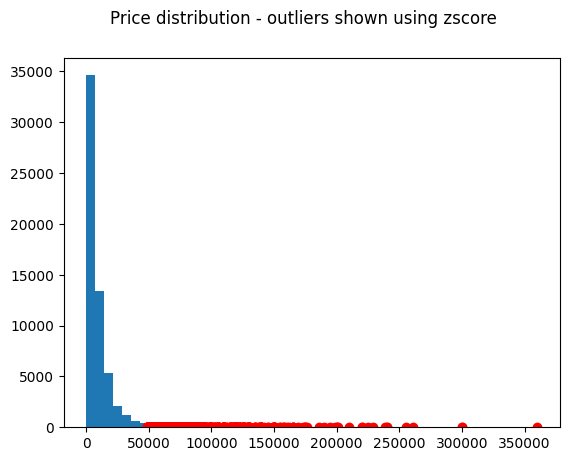

Removed 1041 vehicles.


In [9]:
threshold = 3
price_outliers = df[np.abs(stats.zscore(df['cena'])) > threshold]

plt.hist(df['cena'], bins=50)
plt.scatter(price_outliers['cena'], np.zeros(len(price_outliers)), c='r')
plt.suptitle('Price distribution - outliers shown using zscore')
plt.show()

print("Removed %d vehicles." % len(price_outliers['cena']))

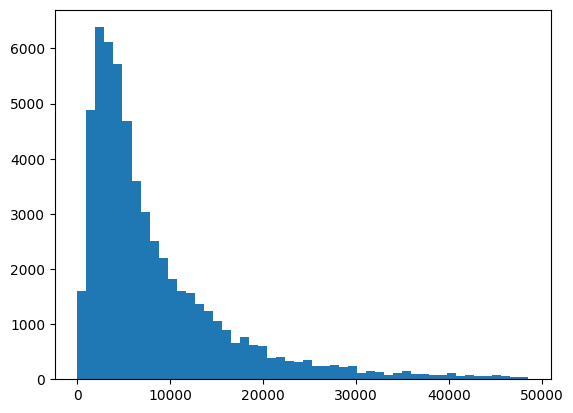

In [10]:
threshold = 3
df = df[np.abs(stats.zscore(df['cena'])) <= threshold]

plt.hist(df['cena'], bins=50)
plt.suptitle('Price distribution - outliers removed using zscore')
plt.suptitle('')
plt.show()

Engine displacement has a horrific range of outliers to the point where the graph shows a single bar value. This is mostly due to user error.<br>
Here we tried to correct that using a statistical approach.

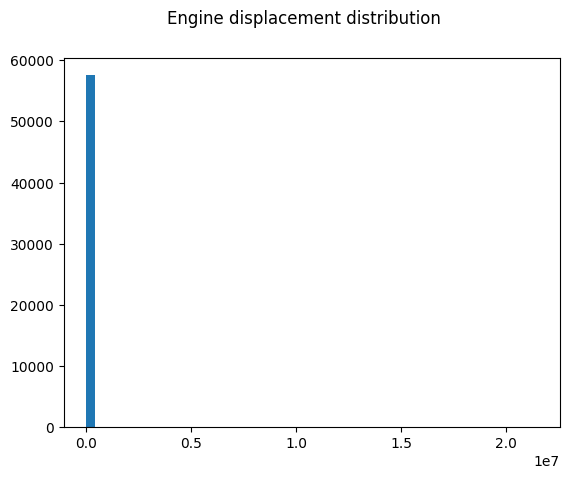

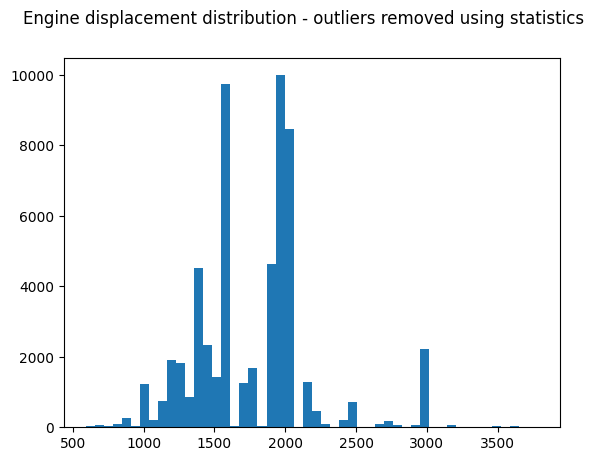

Removed 556 vehicles.


In [11]:
plt.hist(df['kubikaža'], bins=50)
plt.suptitle('Engine displacement distribution')
plt.show()

def remove_outliers(property, multiplier=3.5):
    Q1 = df[property].quantile(0.25)
    Q3 = df[property].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR

    return df[(df[property] >= lower_bound) & (df[property] <= upper_bound)]

df_filtered = remove_outliers('kubikaža')

df_filtered = df_filtered[df_filtered['kubikaža'] > 500]

plt.hist(df_filtered['kubikaža'], bins=50)
plt.suptitle('Engine displacement distribution - outliers removed using statistics')
plt.show()

print("Removed %d vehicles." % (len(df) - len(df_filtered)))

df = df_filtered

We then checked the production year values. We found a reasonable amount of outliers. Some of those were created by user error while entering data, but most of them were just really old vehicles. We determined that the best way to fix this would be to manually remove old vehicles. We will later empirically decide the value span for this removal.

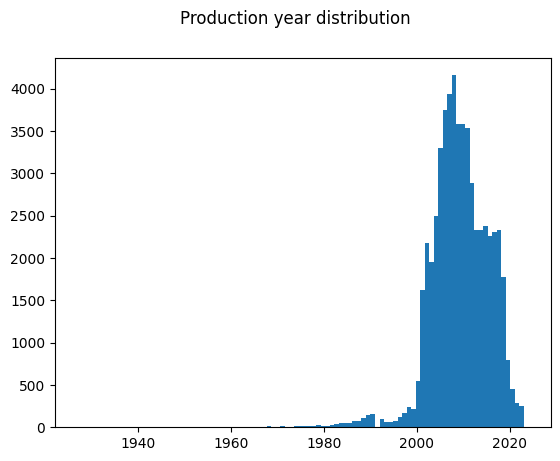

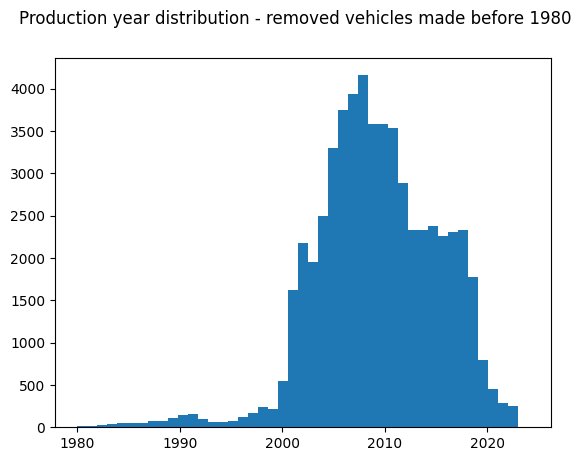

Removed 174 vehicles.


In [12]:
plt.hist(df['godina proizvodnje'], bins=100)
plt.suptitle('Production year distribution')
plt.show()

df_filtered = df[df['godina proizvodnje'] >= 1980]

plt.hist(df_filtered['godina proizvodnje'], bins=45)
plt.suptitle('Production year distribution - removed vehicles made before 1980')
plt.show()

print("Removed %d vehicles." % (len(df) - len(df_filtered)))

df = df_filtered

Here we reviewed the mileage. A lot of these outliers would definitely hurt the model, so we will manually tune the values later in code.

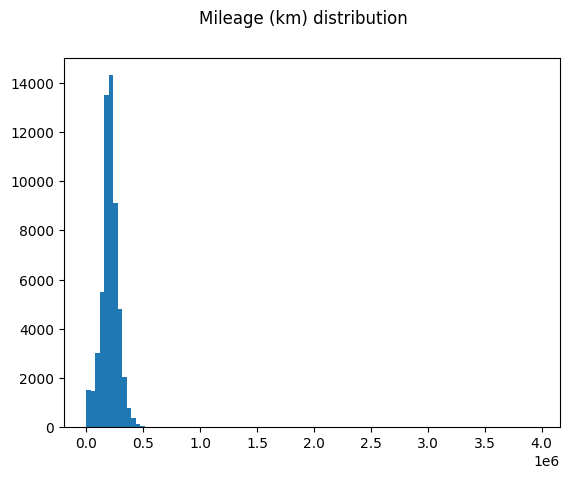

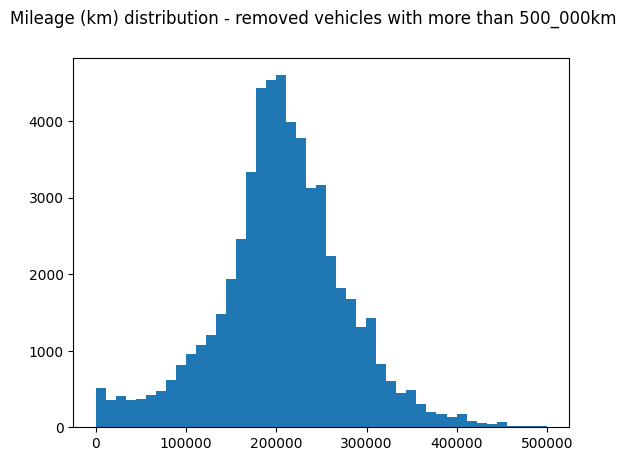

Removed 240 vehicles.


In [13]:
plt.hist(df['kilometraža'], bins=100)
plt.suptitle('Mileage (km) distribution')
plt.show()

df_filtered = df[df['kilometraža'] < 500_000]

plt.hist(df_filtered['kilometraža'], bins=45)
plt.suptitle('Mileage (km) distribution - removed vehicles with more than 500_000km')
plt.show()

print("Removed %d vehicles." % (len(df) - len(df_filtered)))

df = df_filtered

This is what the values looked like after removing the most obvious outliers that were mostly user errors and incredibly distant numbers. All of them will be manually tuned further in the preprocessing part of the code, because it is obvious that there are still loads of outliers.

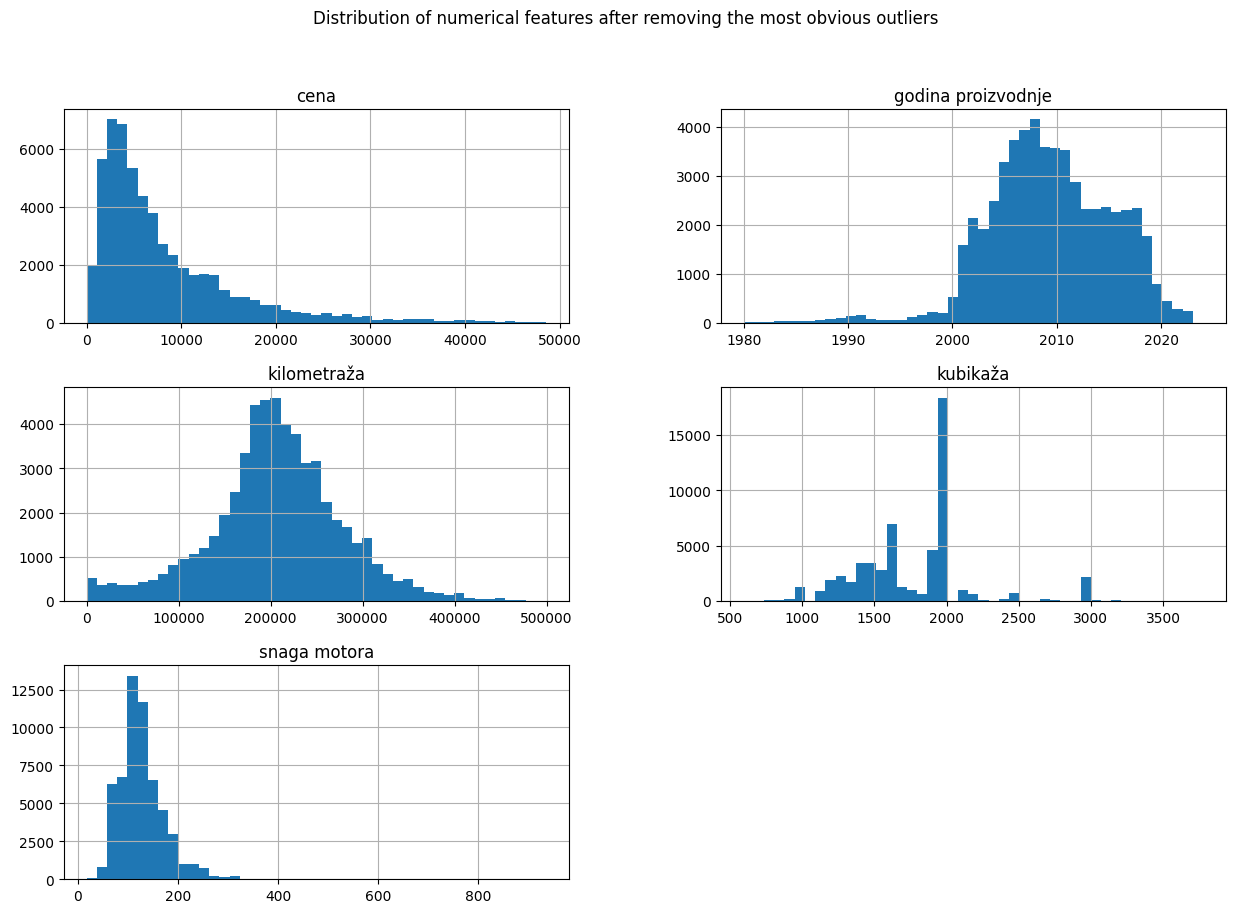

In [14]:
numerical_features = ['cena', 'godina proizvodnje', 'kilometraža', 'kubikaža', 'snaga motora']
df[numerical_features].hist(bins=45, figsize=(15, 10))
plt.suptitle('Distribution of numerical features after removing the most obvious outliers')
plt.show()

Using a correlation heatmap we tried to determine which numerical values are the most relevant to the prediction model. Engine displacement seems to be the least relevant value to the price, and it's also 'contained' within the horsepower, as those two are very much related. And horsepower is a better predictor of price anyway, thus the displacement value will probably be dropped.

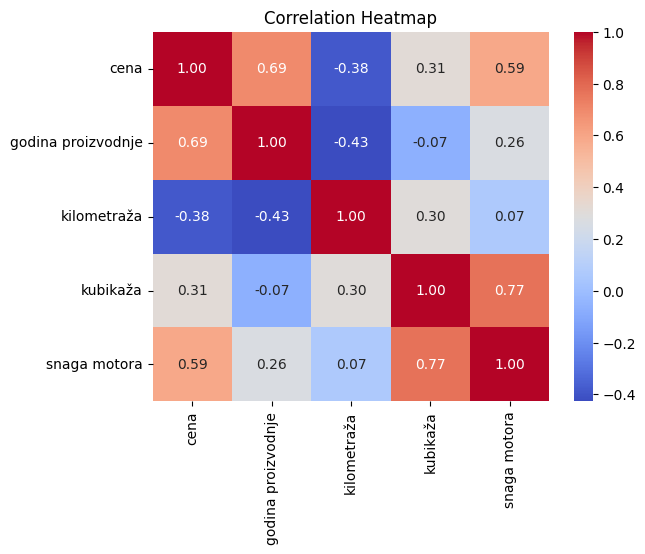

In [15]:
correlation_matrix = df_filtered[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

Here we reviewed the fuel type and its correlation to price. The correlation magnitude is relatively small (-0.21 <> +0.21). This makes the fuel type column a likely candidate for dropping.

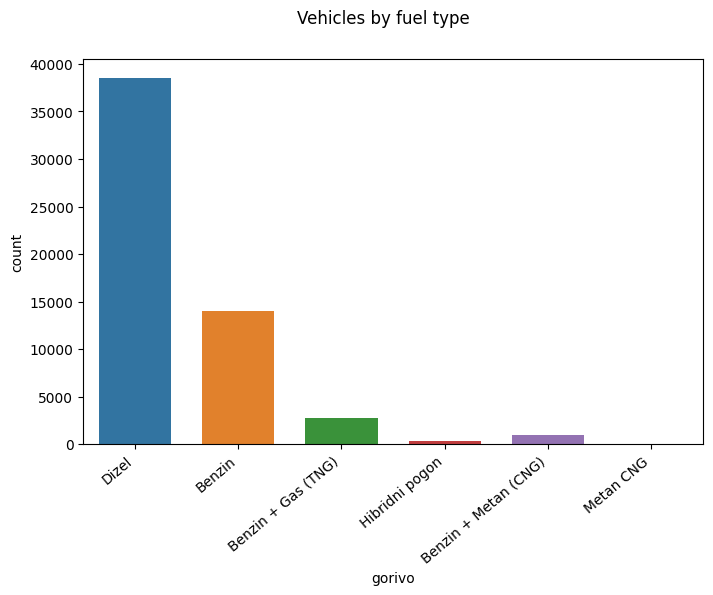

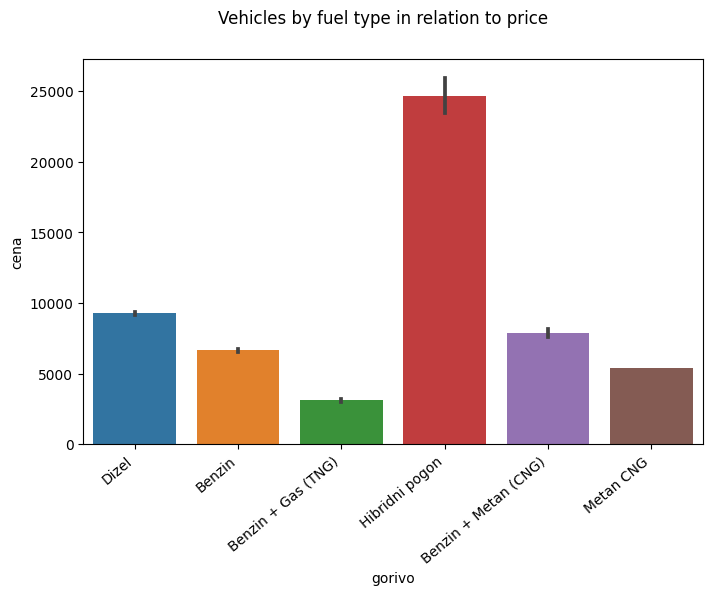

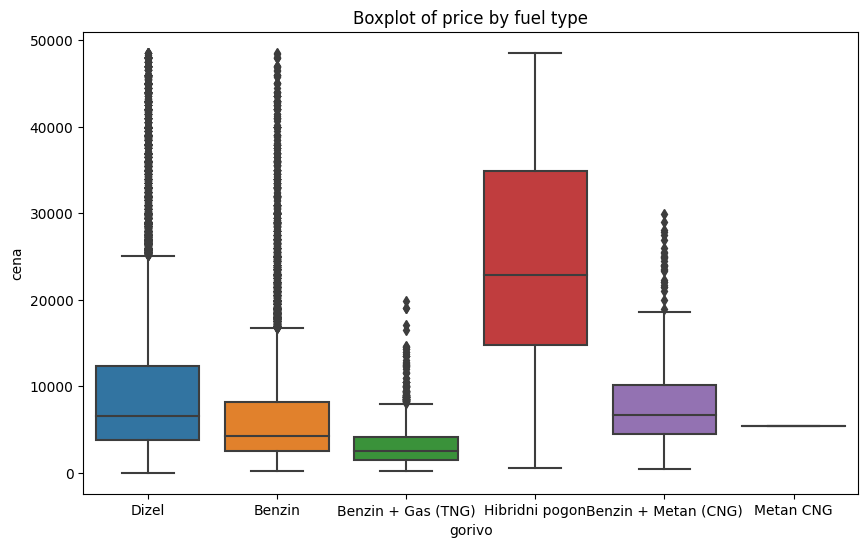

Correlation with price:
gorivo_Benzin                 -0.126309
gorivo_Benzin + Gas (TNG)     -0.151052
gorivo_Benzin + Metan (CNG)   -0.008519
gorivo_Dizel                   0.159016
gorivo_Hibridni pogon          0.169492
gorivo_Metan CNG              -0.001597
dtype: float64


In [16]:
plt.figure(figsize=(8,5))
ax = sns.countplot(x='gorivo', data=df, width=0.7)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.suptitle('Vehicles by fuel type')
plt.show()

plt.figure(figsize=(8,5))
ax = sns.barplot(x='gorivo', y='cena', data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.suptitle('Vehicles by fuel type in relation to price')
plt.show()

encoded_fuel_type = pd.get_dummies(df['gorivo'], prefix='gorivo')
correlation_with_price = encoded_fuel_type.corrwith(df['cena'])
plt.figure(figsize=(10, 6))
sns.boxplot(x='gorivo', y='cena', data=df)
plt.title('Boxplot of price by fuel type')
plt.show()
print("Correlation with price:")
print(correlation_with_price)

Judging by the correlation between AC type and price shown below, it might be a useful label to keep.

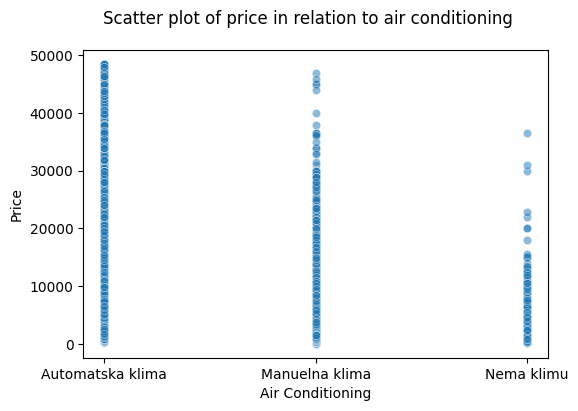

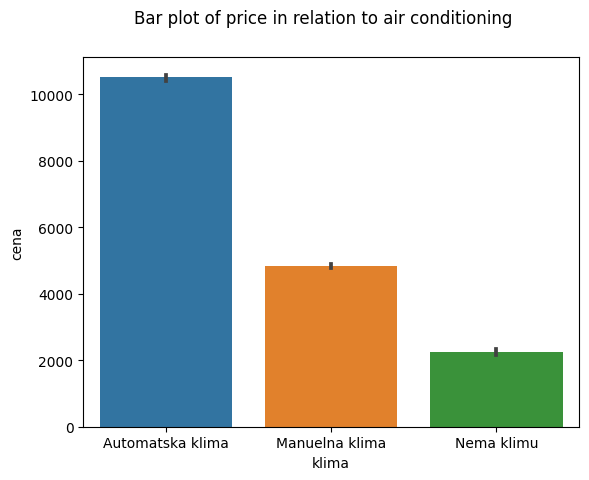

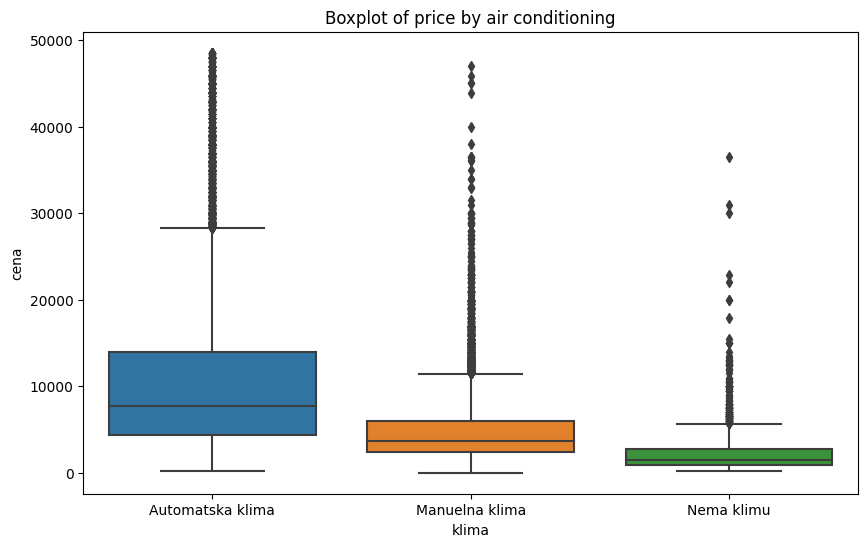

Correlation with price:
klima_Automatska klima    0.362706
klima_Manuelna klima     -0.303113
klima_Nema klimu         -0.164110
dtype: float64


In [17]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x='klima', y='cena', data=df, alpha=0.5)
plt.suptitle('Scatter plot of price in relation to air conditioning')
plt.xlabel('Air Conditioning')
plt.ylabel('Price')
plt.show()

sns.barplot(x='klima', y='cena', data=df)
plt.suptitle('Bar plot of price in relation to air conditioning')
plt.show()

encoded_ac = pd.get_dummies(df['klima'], prefix='klima')
correlation_with_price = encoded_ac.corrwith(df['cena'])

plt.figure(figsize=(10, 6))
sns.boxplot(x='klima', y='cena', data=df)
plt.title('Boxplot of price by air conditioning')
plt.show()

# Print correlation coefficients
print("Correlation with price:")
print(correlation_with_price)

Body type does not seem to be the greatest of predictors, but in some cases SUV it shows an obvious correlation with price.

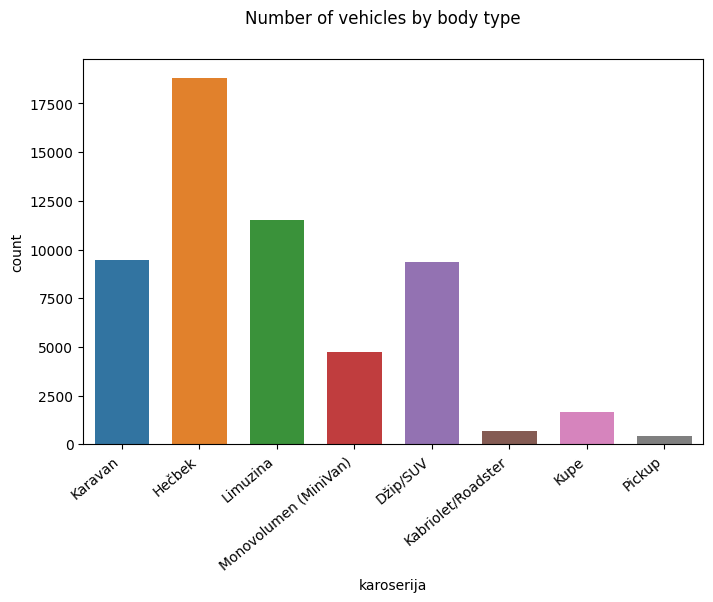

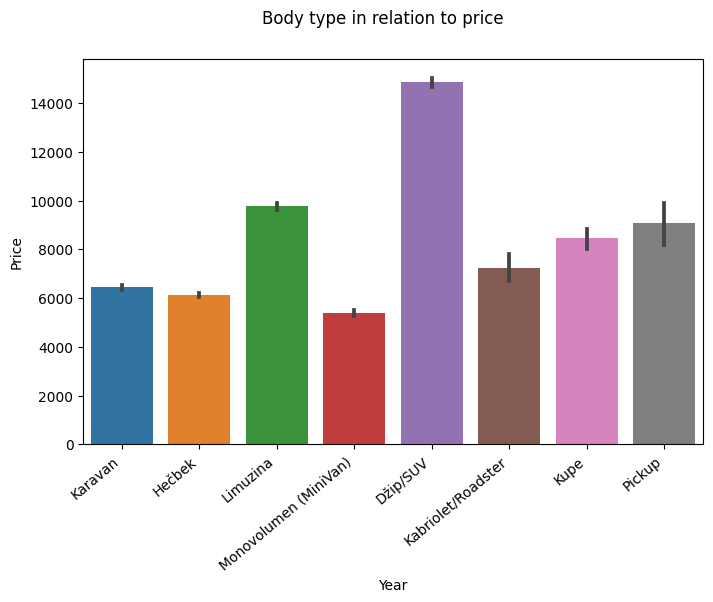

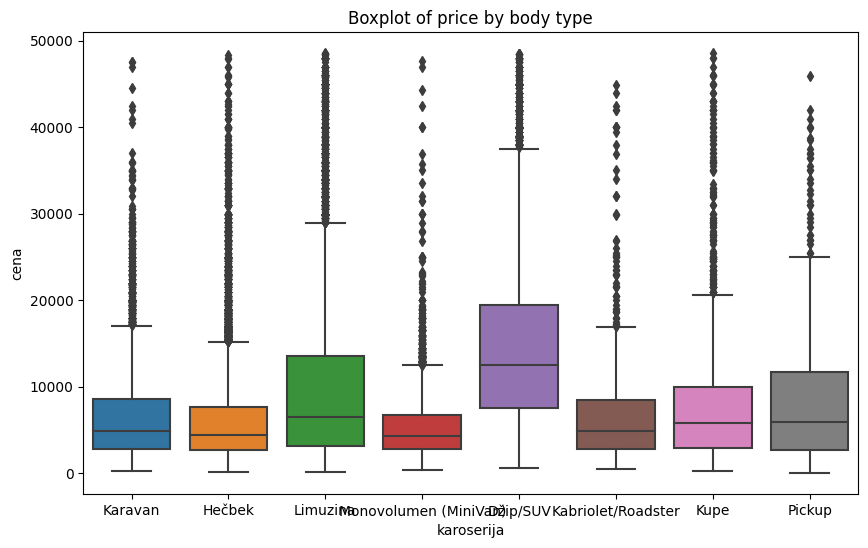

Correlation with price:
karoserija_Džip/SUV                 0.363580
karoserija_Hečbek                  -0.203747
karoserija_Kabriolet/Roadster      -0.015860
karoserija_Karavan                 -0.110394
karoserija_Kupe                     0.001391
karoserija_Limuzina                 0.087848
karoserija_Monovolumen (MiniVan)   -0.116192
karoserija_Pickup                   0.007251
dtype: float64


In [18]:
plt.figure(figsize=(8,5))
ax = sns.countplot(x='karoserija', data=df, width=0.7)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.suptitle('Number of vehicles by body type')
plt.show()

plt.figure(figsize=(8,5))
ax = sns.barplot(x='karoserija', y='cena', data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.suptitle('Body type in relation to price')
plt.xlabel('Year')
plt.ylabel('Price')
plt.show()

encoded_body_type = pd.get_dummies(df['karoserija'], prefix='karoserija')
correlation_with_price = encoded_body_type.corrwith(df['cena'])

plt.figure(figsize=(10, 6))
sns.boxplot(x='karoserija', y='cena', data=df)
plt.title('Boxplot of price by body type')
plt.show()

print("Correlation with price:")
print(correlation_with_price)

As determined before, age does immensely impact a car price. Here we can see that the data follows a somewhat obvious pattern, but there might be some outliers that need removing.

<Figure size 1200x600 with 0 Axes>

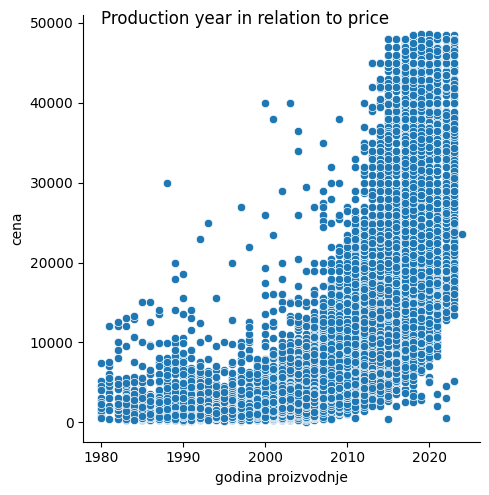

In [19]:
plt.figure(figsize=(12,6))
sns.relplot(x='godina proizvodnje', y='cena', data=df)
plt.suptitle('Production year in relation to price')
plt.show()

In [20]:
def print_year_price(d, y, p):
  print(f"Number of cars with year of production <= {y} and price higher than {p}: {len(d[(d['godina proizvodnje'] <= y) & (d['cena'] > p)])}")

print(f"Vehicles with production year smaller than 2002: {len(df[df['godina proizvodnje'] < 2002])}")
df_above_2002 = df[df['godina proizvodnje'] >= 2002]
print_year_price(df_above_2002, 2005, 6000)
print_year_price(df_above_2002, 2007, 12000)
print_year_price(df_above_2002, 2010, 15000)

Vehicles with production year smaller than 2002: 3925
Number of cars with year of production <= 2005 and price higher than 6000: 391
Number of cars with year of production <= 2007 and price higher than 12000: 95
Number of cars with year of production <= 2010 and price higher than 15000: 196


Same goes for the mileage. Some outliers need to be dealt with. Also, extreme values should probably be removed by hand, but carefully enough as to not remove too many rows.

<Figure size 1200x600 with 0 Axes>

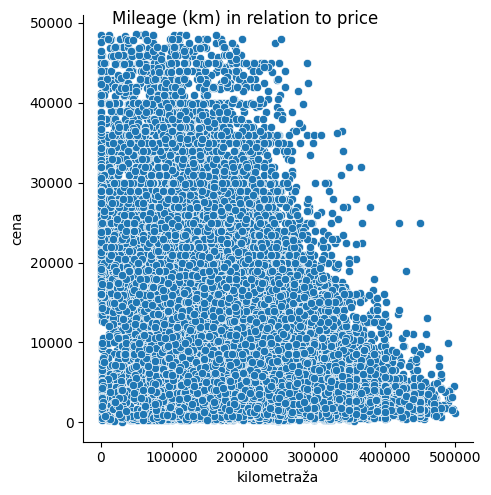

Number of cars with mileage greater than 500,000: 0
Number of cars with mileage greater than 400,000: 387
Number of cars with mileage greater than 375,000: 829
Number of cars with mileage greater than 350,000: 1430
Number of cars with mileage greater than 300,000: 4519


In [21]:
plt.figure(figsize=(12,6))
sns.relplot(x='kilometraža', y='cena', data=df)
plt.suptitle('Mileage (km) in relation to price')
plt.show()

mileage_filter = df[df['kilometraža'] > 500_000]
print(f"Number of cars with mileage greater than 500,000: {len(mileage_filter)}")
mileage_filter = df[df['kilometraža'] > 400_000]
print(f"Number of cars with mileage greater than 400,000: {len(mileage_filter)}")
mileage_filter = df[df['kilometraža'] > 375_000]
print(f"Number of cars with mileage greater than 375,000: {len(mileage_filter)}")
mileage_filter = df[df['kilometraža'] > 350_000]
print(f"Number of cars with mileage greater than 350,000: {len(mileage_filter)}")
mileage_filter = df[df['kilometraža'] > 300_000]
print(f"Number of cars with mileage greater than 300,000: {len(mileage_filter)}")

The number of doors does not seem to have a decent correlation compared to other metrics.

<Figure size 1200x600 with 0 Axes>

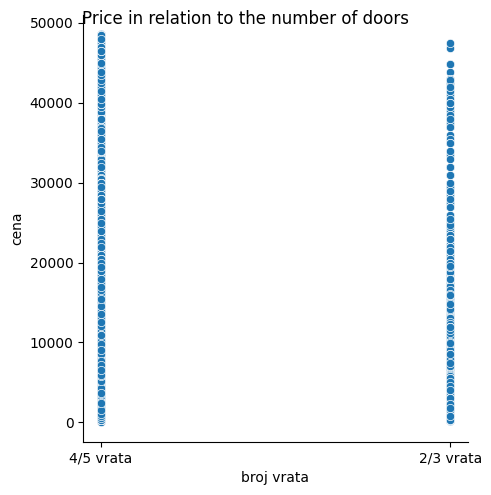

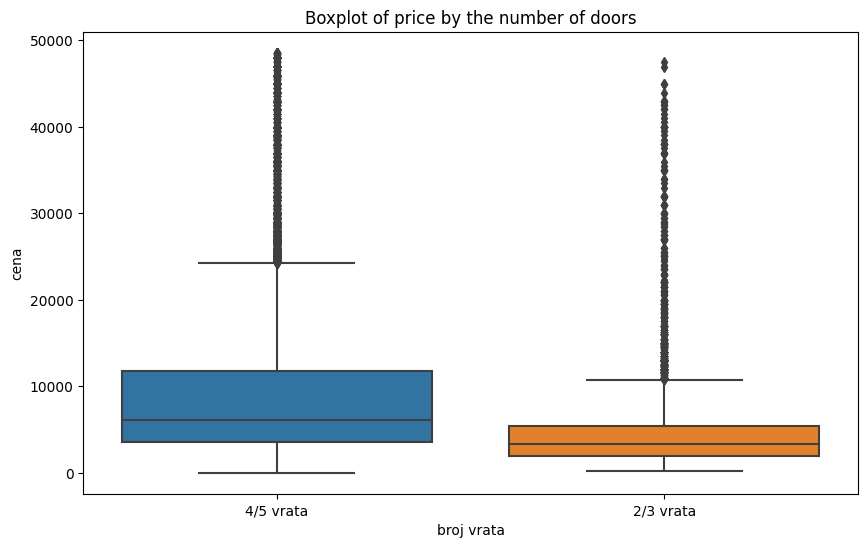

Correlation with price:
broj vrata_2/3 vrata   -0.173634
broj vrata_4/5 vrata    0.173634
dtype: float64


In [22]:
plt.figure(figsize=(12,6))
sns.relplot(x='broj vrata', y='cena', data=df)
plt.suptitle('Price in relation to the number of doors')
plt.show()

encoded_door_num = pd.get_dummies(df['broj vrata'], prefix='broj vrata')
correlation_with_price = encoded_door_num.corrwith(df['cena'])

plt.figure(figsize=(10, 6))
sns.boxplot(x='broj vrata', y='cena', data=df)
plt.title('Boxplot of price by the number of doors')
plt.show()

print("Correlation with price:")
print(correlation_with_price)

In some cases, it seems that the transmission type has a sufficient enough correlation to be kept.

<Figure size 800x200 with 0 Axes>

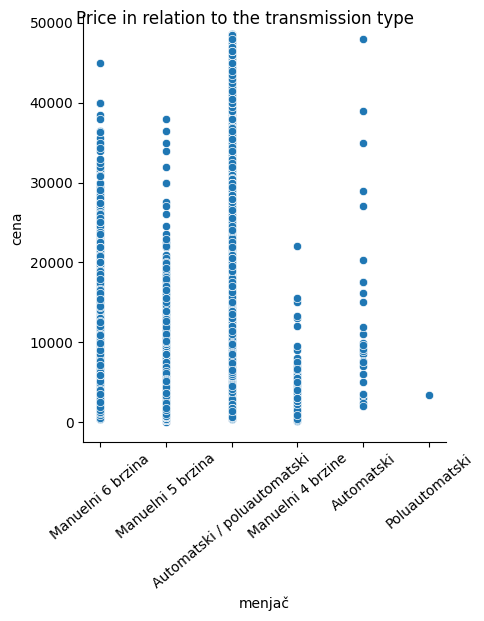

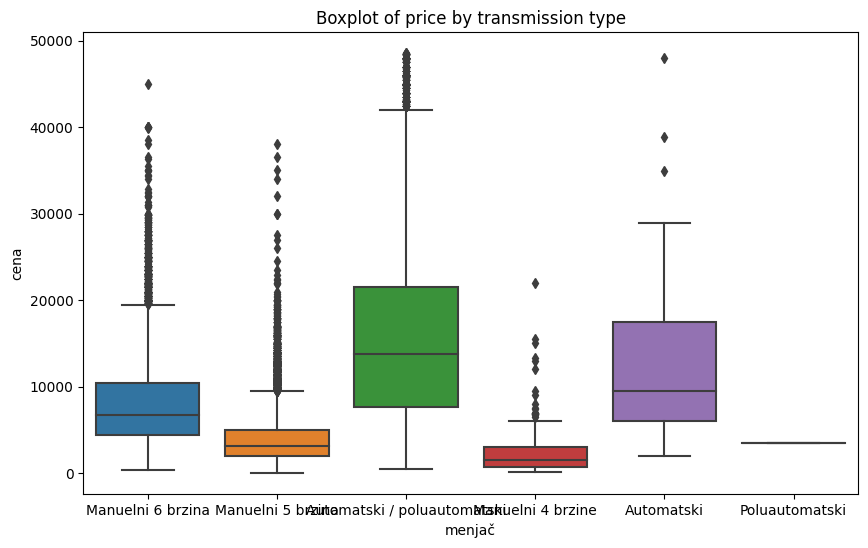

Correlation with price:
menjač_Automatski                     0.015317
menjač_Automatski / poluautomatski    0.559973
menjač_Manuelni 4 brzine             -0.054072
menjač_Manuelni 5 brzina             -0.454261
menjač_Manuelni 6 brzina             -0.044066
menjač_Poluautomatski                -0.002636
dtype: float64


In [23]:
plt.figure(figsize=(8, 2))
g = sns.relplot(x='menjač', y='cena', data=df)
g.set_xticklabels(rotation=40)
plt.suptitle('Price in relation to the transmission type')
plt.show()

encoded_transmission = pd.get_dummies(df['menjač'], prefix='menjač')
correlation_with_price = encoded_transmission.corrwith(df['cena'])

plt.figure(figsize=(10, 6))
sns.boxplot(x='menjač', y='cena', data=df)
plt.title('Boxplot of price by transmission type')
plt.show()

print("Correlation with price:")
print(correlation_with_price)

The correlation between the engine horsepower value and price is obvious. It is a question as to we should remove many outliers. At the end of the day, all the powerful cars are expensive. There is a growing trend in the data.

<Figure size 1200x600 with 0 Axes>

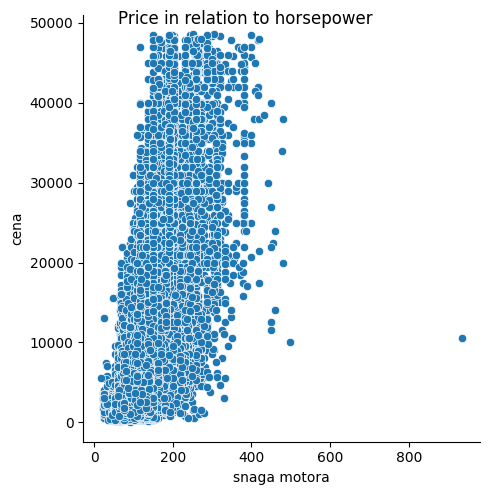

Number of cars with horsepower greater than 700: 1
Number of cars with horsepower greater than 500: 1
Number of cars with horsepower greater than 450: 8
Number of cars with horsepower greater than 425: 15
Number of cars with horsepower greater than 400: 25
Number of cars with horsepower greater than 375: 74
Number of cars with horsepower greater than 350: 101
Number of cars with horsepower greater than 300: 378
Number of cars with horsepower greater than 175 and with price less than 2000: 95
Number of cars with horsepower smaller than 20 and with price more than 10000: 1


In [30]:
plt.figure(figsize=(12,6))
sns.relplot(x='snaga motora', y='cena', data=df)
plt.suptitle('Price in relation to horsepower')
plt.show()

horsepower_filter = df[df['snaga motora'] > 700]
print(f"Number of cars with horsepower greater than 700: {len(horsepower_filter)}")
horsepower_filter = df[df['snaga motora'] > 500]
print(f"Number of cars with horsepower greater than 500: {len(horsepower_filter)}")
horsepower_filter = df[df['snaga motora'] > 450]
print(f"Number of cars with horsepower greater than 450: {len(horsepower_filter)}")
horsepower_filter = df[df['snaga motora'] > 425]
print(f"Number of cars with horsepower greater than 425: {len(horsepower_filter)}")
horsepower_filter = df[df['snaga motora'] > 400]
print(f"Number of cars with horsepower greater than 400: {len(horsepower_filter)}")
horsepower_filter = df[df['snaga motora'] > 375]
print(f"Number of cars with horsepower greater than 375: {len(horsepower_filter)}")
horsepower_filter = df[df['snaga motora'] > 350]
print(f"Number of cars with horsepower greater than 350: {len(horsepower_filter)}")
horsepower_filter = df[df['snaga motora'] > 300]
print(f"Number of cars with horsepower greater than 300: {len(horsepower_filter)}")

horsepower_filter = df[(df['snaga motora'] >= 160) & (df['cena'] < 2000)]
print(f"Number of cars with horsepower greater than 160 and with price less than 2000: {len(horsepower_filter)}")

horsepower_filter = df[(df['snaga motora'] < 25) & (df['cena'] > 10000)]
print(f"Number of cars with horsepower smaller than 20 and with price more than 10000: {len(horsepower_filter)}")

In [38]:
hp, pr = 200, 3000
print(f"Number of cars with horsepower greater than {hp} and price lower than {pr}: {len(df[(df['snaga motora'] >= hp) & (df['cena'] < pr)])}")
hp, pr = 300, 15000
print(f"Number of cars with horsepower greater than {hp} and price lower than {pr}: {len(df[(df['snaga motora'] >= hp) & (df['cena'] < pr)])}")

km, pr = 300_000, 35000
print(f"Number of cars with mileage (km) greater than {km} and price higher than {pr}: {len(df[(df['kilometraža'] >= km) & (df['cena'] > pr)])}")
km, pr = 350_000, 25000
print(f"Number of cars with mileage (km) greater than {km} and price higher than {pr}: {len(df[(df['kilometraža'] >= km) & (df['cena'] > pr)])}")

Number of cars with horsepower greater than 200 and price lower than 3000: 36
Number of cars with horsepower greater than 300 and price lower than 15000: 31
Number of cars with mileage (km) greater than 300000 and price higher than 35000: 3
Number of cars with mileage (km) greater than 350000 and price higher than 25000: 4
3925
